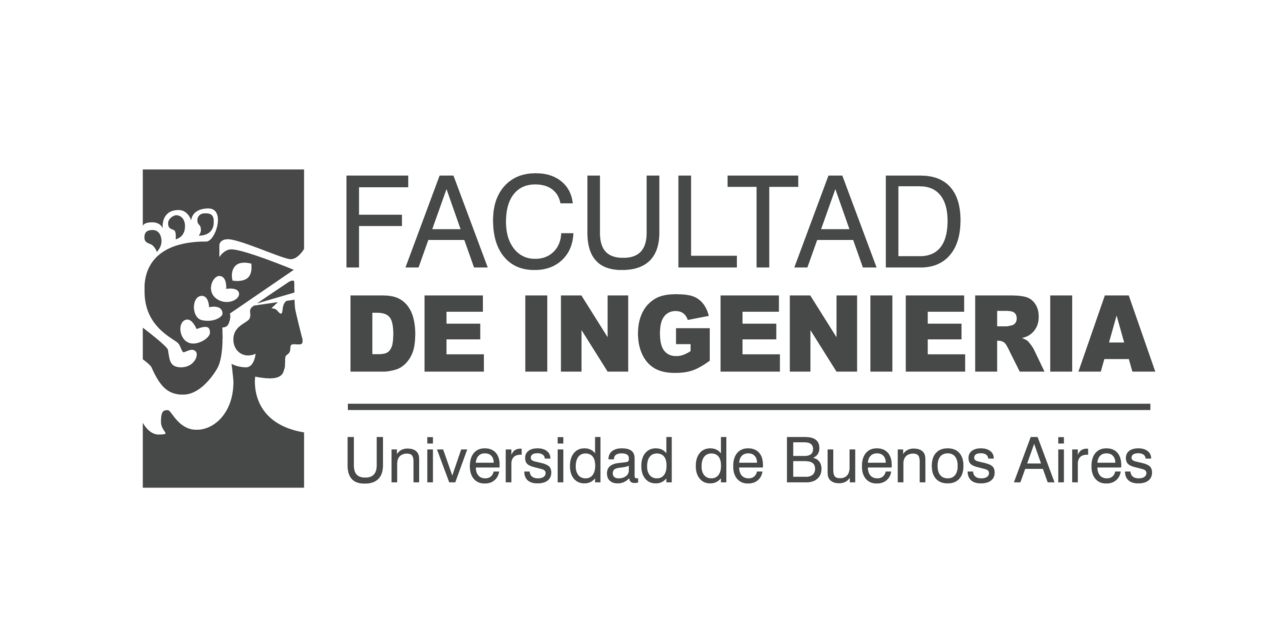

## Aprendizaje Profundo - TP1
### Cohorte 18 - 1er bimestre 2025

**Profesores:** <br />
Dr. Ing. Marcos Maillot - marcos_maillot@yahoo.com.ar <br />
Dr. Antonio Zarauz - hedrergudene@gmail.com <br />
Mg. Ing. Gerardo Vilcamiza - gerardox2000@gmail.com <br />

**Alumnos:** <br />
Mg. Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/joagonzalez/ceia-aprendizaje-profundo <br />

## Consigna

Este primer TP comienza desde el día después de la clase 2 (12 de marzo) y la ventana de entrega estará abierta hasta las **23hs del lunes 7 de abril (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un link a un notebook de google colab (permitir acceso a gerardo.vilcamiza@ieee.org y gvilcamiza.ext@fi.uba.ar) y **se realizará en el siguiente link de google forms: [link](https://forms.gle/ViVSD2CG8TcrZ9wBA)**. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

NO ES NECESARIO QUE NOS ENVIEN COREEO AVISANDO DE LA ENTREGA.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP1.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP1-Co18.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## **PREGUNTA 1**

### Teoria

#### **Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa**

En este ejercicio se compararán los optimizadores Gradiente Descendente (GD) y Adam en la minimización de una función de costo basada en una red neuronal de una sola neurona:
$$
z = w x + b
$$
Con activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

Se analizará la trayectoria de aprendizaje de ambos algoritmos y se evaluará su eficiencia con diferentes tasas de aprendizaje (learning rate).


La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde $w$ y $b$ son los parámetros a optimizar.


Si bien es cierto, en estos experimentos estamos comparando optimizadores (GD vs Adam), y no entrenando un modelo como tal, de igual forma se necesitará una especie de dataset. Este será sintético y solo de prueba, por ende tendrán cierta libertad para elegir sus valores. Sin embargo deberán tomar en cuenta que cumpla la siguiente estructura:

x = np.linspace(ini, fin, n)

donde $x$ es un array de una sola dimensión y con $n$ cantidad de valores. Y tiene un rango de valores desde $ini$ hasta $fin$. Recomiendo que sean los mismos valores solo que con el signo cambiado, por ejemplo $ini=-3 , fin=3$.


Y con un target $y$:

$y = \text{función\_no\_lineal}(x) + \text{ruido}$

donde $y$ es también un vector de una sola dimensión de tamaño $n$ que sigue un patrón no lineal con respecto a `x` adicionando un ruido que puede ser creado con algunas de las funciones del paquete $np.random$.


### Dependencias y Clases base

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install seaborn

In [50]:
import numpy as np
import matplotlib.pyplot as plt

#### Derivación del gradiente con la regla de la cadena

Queremos calcular los gradientes de la función de costo respecto a los parámetros \( w \) y \( b \). Usamos la **regla de la cadena**:

$$
\frac{\partial J}{\partial w} = \frac{\partial J}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z} \cdot \frac{\partial z}{\partial w}
$$

Donde:

$$
\frac{\partial z}{\partial w} = x
$$

$$
\frac{\partial \hat{y}}{\partial z} = 1 - \tanh^2(z)
$$

$$
\frac{\partial J}{\partial \hat{y}} = 2(\hat{y} - y)
$$

Entonces:

$$
\frac{\partial J}{\partial w} = 2(\hat{y} - y) \cdot (1 - \tanh^2(z)) \cdot x
$$

Y de forma análoga, para el sesgo:

$$
\frac{\partial J}{\partial b} = 2(\hat{y} - y) \cdot (1 - \tanh^2(z))
$$

In [74]:
import numpy as np

class SingleNeuron:
    """Clase para una única neurona. Version vectorizada, se pasa el dataset completo."""
    def __init__(self):
        self.w = np.random.randn()
        self.b = np.random.randn()

    def activation(self, z):
        """Función de activación: tanh."""
        return np.tanh(z)

    def activation_derivative(self, z):
        """Derivada de tanh."""
        return 1 - np.tanh(z) ** 2

    def forward(self, x):
        """Propagación hacia adelante."""
        z = self.w * x + self.b
        return self.activation(z)

    def compute_loss(self, y_hat, y):
        """Cálculo del error cuadrático medio."""
        return np.mean((y_hat - y) ** 2)

    def backward(self, x, y):
        """Cálculo de gradientes de w y b."""
        m = len(x)
        z = self.w * x + self.b
        y_hat = self.activation(z)

        dz = 2 * (y_hat - y) * self.activation_derivative(z)
        # Se devuelven valores medios de los gradientes
        dw = np.mean(dz * x)
        db = np.mean(dz)
        return dw, db

In [9]:
from abc import ABC, abstractmethod

class Optimizer: 
    class Optimizer(ABC):
        @abstractmethod
        def __init__(self, *args, **kwargs):
            pass

        @abstractmethod
        def step(self, neuron: SingleNeuron, dw: float, db: float):
            pass

In [10]:
class GradientDescentOptimizer(Optimizer):
    """Optimizador por descenso de gradiente."""
    def __init__(self, lr=0.01):
        self.lr = lr

    def step(self, neuron: SingleNeuron, dw: float, db: float):
        neuron.w -= self.lr * dw
        neuron.b -= self.lr * db

In [11]:
class AdamOptimizer(Optimizer):
    """Optimizador Adam."""
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_w = 0
        self.v_w = 0
        self.m_b = 0
        self.v_b = 0
        self.t = 0

    def step(self, neuron: SingleNeuron, dw: float, db: float):
        self.t += 1

        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dw
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dw ** 2)
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * db
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (db ** 2)

        m_w_corr = self.m_w / (1 - self.beta1 ** self.t)
        v_w_corr = self.v_w / (1 - self.beta2 ** self.t)
        m_b_corr = self.m_b / (1 - self.beta1 ** self.t)
        v_b_corr = self.v_b / (1 - self.beta2 ** self.t)

        neuron.w -= self.lr * m_w_corr / (np.sqrt(v_w_corr) + self.epsilon)
        neuron.b -= self.lr * m_b_corr / (np.sqrt(v_b_corr) + self.epsilon)

In [28]:
def generate_dataset(n: int = 10000, ini: int = -3, fin: int = 3, noise_std: float = 0.1):
    x = np.linspace(ini, fin, n)
    y = np.tanh(x) + np.random.normal(0, noise_std, size=x.shape)
    return x, y

In [75]:
def train(neuron: SingleNeuron, optimizer: Optimizer, x, y, epochs=100, verbose=True):
    """
    Entrenamiento de la neurona, se entrena con el dataset completo en cada epoca ya que x, y son vectores.
    """
    # Inicializar lista de pérdidas
    losses = []

    for epoch in range(epochs):
        # Pasada forward
        y_hat = neuron.forward(x)

        # Computar perdida
        loss = neuron.compute_loss(y_hat, y)
        losses.append(loss)

        # Pasada backward
        dw, db = neuron.backward(x, y)

        # Actualizar pesos de la red
        optimizer.step(neuron, dw, db)

        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch:3d} | Loss: {loss:.6f} | w: {neuron.w:.4f} | b: {neuron.b:.4f}")

    return losses

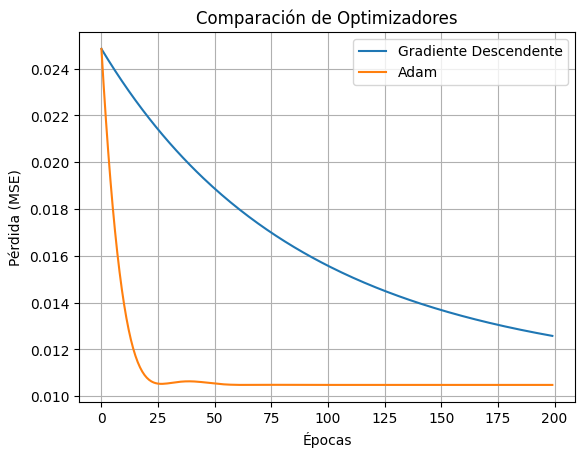

In [ ]:
# Generar dataset
x, y = generate_dataset(n=100, ini=-3, fin=3, noise_std=0.1)

# Inicializar neuronas independientes para comparar
neuron_gd = SingleNeuron()
neuron_adam = SingleNeuron()

# Copiar los mismos pesos iniciales para comparación justa
neuron_adam.w = neuron_gd.w
neuron_adam.b = neuron_gd.b

# Optimizadores
gd = GradientDescentOptimizer(lr=0.01)
adam = AdamOptimizer(lr=0.01)

# Entrenar
losses_gd = train(neuron_gd, gd, x, y, epochs=200, verbose=False)
losses_adam = train(neuron_adam, adam, x, y, epochs=200, verbose=False)

# Graficar comparación
plt.plot(losses_gd, label="Gradiente Descendente")
plt.plot(losses_adam, label="Adam")
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("Comparación de Optimizadores")
plt.legend()
plt.grid(True)
plt.show()

### 1a) Implementación del Gradiente Descendente (1 punto)

#### Consigna

- Implementar el algoritmo del Gradiente Descendente (GD) para minimizar ($J(w, b)$).
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Inicializar valores de ($w$) y ($b$) de manera aleatoria con `np.random.randn()` para cada learning rate.
- Graficar la función de Costo ($J(w, b)$) VS número de época

El optimizador del Gradiente Descendente se debe implementar haciendo el código desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

#### Desarrollo

Epoch   0 | Loss: 1.449727 | w: 0.0825 | b: -1.3728
Epoch  10 | Loss: 0.172482 | w: 0.9067 | b: -0.7572
Epoch  20 | Loss: 0.062597 | w: 1.0429 | b: -0.4872
Epoch  30 | Loss: 0.032364 | w: 1.0829 | b: -0.3266
Epoch  40 | Loss: 0.020281 | w: 1.0932 | b: -0.2214
Epoch  50 | Loss: 0.014890 | w: 1.0918 | b: -0.1506
Epoch  60 | Loss: 0.012376 | w: 1.0856 | b: -0.1025
Epoch  70 | Loss: 0.011176 | w: 1.0778 | b: -0.0699
Epoch  80 | Loss: 0.010588 | w: 1.0697 | b: -0.0479
Epoch  90 | Loss: 0.010291 | w: 1.0619 | b: -0.0331
Epoch  99 | Loss: 0.010145 | w: 1.0554 | b: -0.0240
Epoch   0 | Loss: 0.248996 | w: 0.7804 | b: -0.8798
Epoch  10 | Loss: 0.209507 | w: 0.8210 | b: -0.8329
Epoch  20 | Loss: 0.179922 | w: 0.8542 | b: -0.7906
Epoch  30 | Loss: 0.156855 | w: 0.8820 | b: -0.7520
Epoch  40 | Loss: 0.138329 | w: 0.9055 | b: -0.7164
Epoch  50 | Loss: 0.123113 | w: 0.9257 | b: -0.6833
Epoch  60 | Loss: 0.110392 | w: 0.9432 | b: -0.6525
Epoch  70 | Loss: 0.099606 | w: 0.9585 | b: -0.6237
Epoch  80 | 

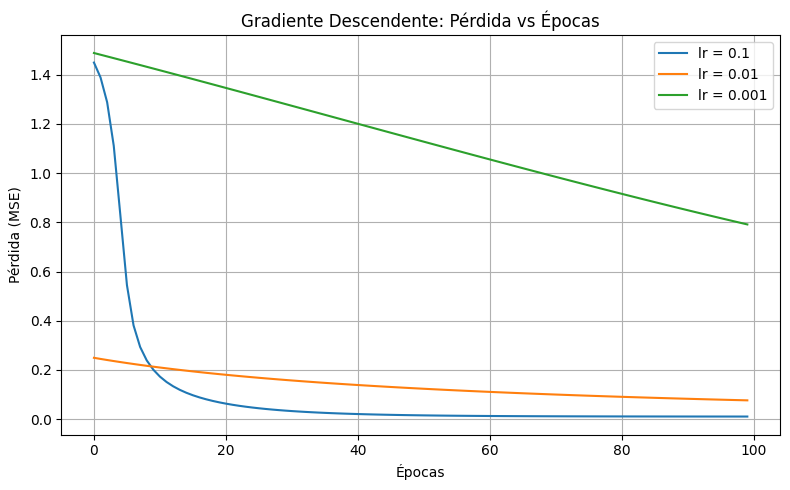

In [73]:
# Dataset sintético
x, y = generate_dataset(n=10000, ini=-3, fin=3, noise_std=0.1)

# Learning rates a probar
learning_rates = [0.1, 0.01, 0.001]
loss_histories = []

for lr in learning_rates:
    # Inicializar neurona con w y b aleatorios
    neuron = SingleNeuron()  # Esto genera nuevos w y b
    optimizer = GradientDescentOptimizer(lr=lr)

    # Entrenar 100 épocas
    losses = train(neuron, optimizer, x, y, epochs=100, verbose=True)

    loss_histories.append((lr, losses))

# Graficar resultados
plt.figure(figsize=(8, 5))

for lr, losses in loss_histories:
    plt.plot(losses, label=f"lr = {lr}")

plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("Gradiente Descendente: Pérdida vs Épocas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 1b) Implementación de Adam (1.5 puntos)

#### Consigna

- Implementar el algoritmo de Adam para minimizar ($J(w, b)$).  
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Utilizar los mismos valores de ($w$) y ($b$) que se usaron para GD para cada diferente learning rate.
- Graficar la función de Costo ($J(w, b)$) VS número de época
- Comparar el resultado y rendimiento de Adam VS GD para cada learning rate.

Al igual que para GD, el optimizador Adam también se debe implementar desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.


 Comparando GD vs Adam con learning rate = 0.1


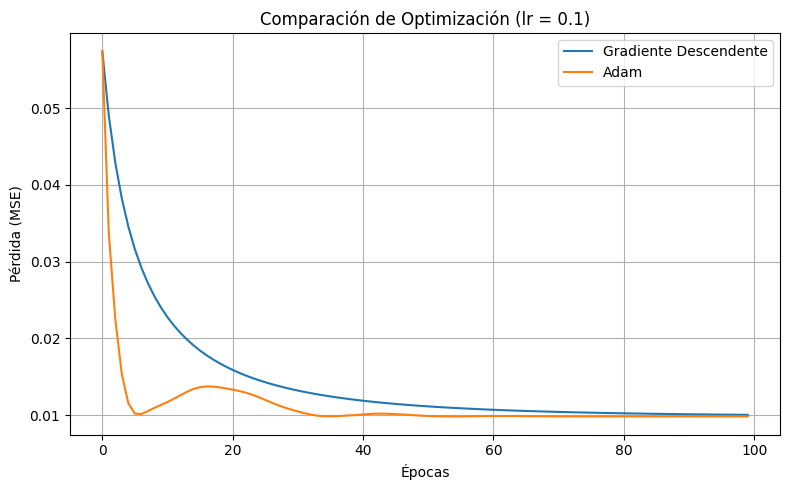


 Comparando GD vs Adam con learning rate = 0.01


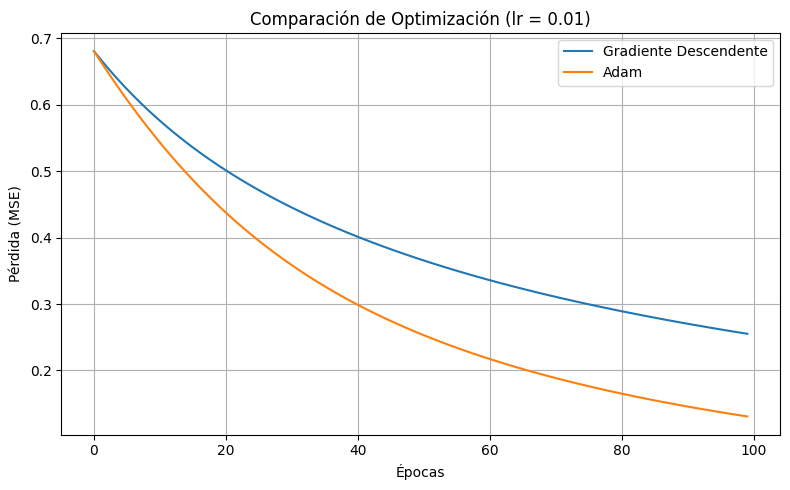


 Comparando GD vs Adam con learning rate = 0.001


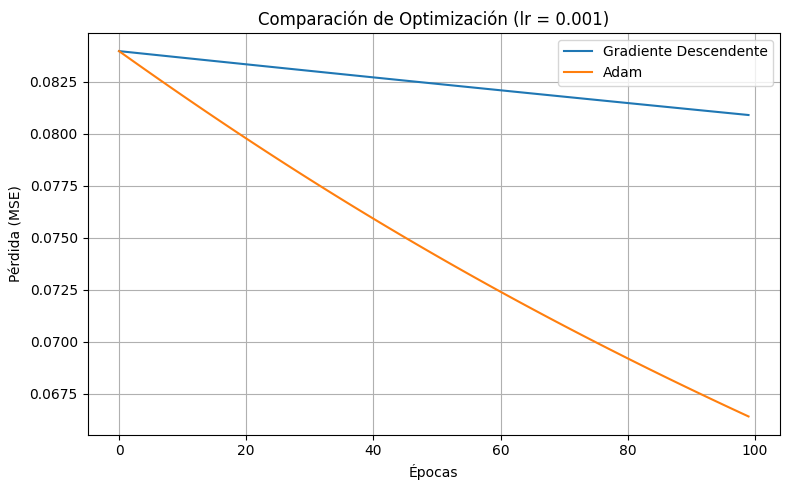

In [79]:
learning_rates = [0.1, 0.01, 0.001]

for lr in learning_rates:
    print(f"\n Comparando GD vs Adam con learning rate = {lr}")

    # Inicializar neurona y guardar pesos
    neuron_gd = SingleNeuron()
    w_init = neuron_gd.w
    b_init = neuron_gd.b

    # Entrenar con GD
    optimizer_gd = GradientDescentOptimizer(lr=lr)
    losses_gd = train(neuron_gd, optimizer_gd, x, y, epochs=100, verbose=False)

    # Inicializar neurona Adam con mismos pesos
    neuron_adam = SingleNeuron()
    neuron_adam.w = w_init
    neuron_adam.b = b_init

    # Entrenar con Adam
    optimizer_adam = AdamOptimizer(lr=lr)
    losses_adam = train(neuron_adam, optimizer_adam, x, y, epochs=100, verbose=False)

    # Graficar comparación
    plt.figure(figsize=(8, 5))
    plt.plot(losses_gd, label="Gradiente Descendente")
    plt.plot(losses_adam, label="Adam")
    plt.title(f"Comparación de Optimización (lr = {lr})")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 1c) Visualización en 3D de la trayectoria de aprendizaje (0.5 puntos)

#### Consigna

- Graficar en 3D la trayectoria del aprendizaje de ambos optimizadores sobre la superficie de la función de costo ($J(w, b)$). Se debe elegir un solo learning rate.
- Comparar cómo se mueven en el espacio de parámetros y qué diferencias existen en la convergencia.
- Recomiendo utilizar `mpl_toolkits.mplot3d` y `np.meshgrid`, pero queda a su criterio la elección de funciones a usar para lograr el gráfico.

## **PREGUNTA 2**

Descargar el dataset del siguiente link: https://drive.google.com/file/d/1hiLnMm7ooBj-wJdz0F4vpvjx9DcEgAkg/view?usp=sharing.

El dataset consiste en compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizarlo para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro.


### 2a) EDA y preparación del dataset (2 puntos)
Realizar el análisis exploratorio del dataset (EDA) con las herramientas vistas en materias anteriores. Pre-procesar las variables, explicar los criterios utilizados y analizar las distribuciones.

Vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece a una categoría: "Casual" (gasta menos de 5000), "Gama media" (gasta entre 5000 y 10000), "Fiel" (gasta entre 10000 y 15000) o a "Premium" (gasta más de 15000).

### 2b) Benchmark de modelos de ML clásico  (1 punto)
Definir uno o varios puntos de comparación (benchmark) para comparar entre sí al menos 2 modelos distintos. Estos deben ser modelos de ML clásico de la librería `sklearn` de fácil y rápido entrenamiento.

### 2c) Modelo de deep leaning sin embeddings (1.5 puntos)
Entrenar un modelo de deep learning usando Pytorch que no utilice embeddings, **descartando el `product_id` y `user_id`**. Graficar las evoluciones de la función de costo y la metrica de validacion. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.

### 2d) Modelo de deep leaning con embeddings (2 puntos)
Entrenar un modelo de deep learning usando Pytorch que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones de la función de costo y la métrica de validación. Explicar el proceso de iteración utilizado para conseguir los resultados y justificar los resultados obtenidos. **Comparar contra el modelo sin embeddings**.
Recordar que tanto para el punto 2c) como el 2d) pueden usarse herramientas como regularización y prueba de hiperpametros para conseguir mejores resultados.

### 2e) Encontrar usuarios similares (0.5 puntos)
Para el modelo del punto 2c) implementar una función que a reciba un id de usuario y sugiera **n** cantidad de usuarios que tuvieron un comportamiento de compras similar.